# Pairs exploration
Preparing data and performing cluster analysis

**NOTES**
* Decide the train/test spilt &rarr; what is the formation period, on which the pairs are formed/detected
* This approach will only detectd pairs within the clustering/cointegration framework. May find useful pairs outside this framework
***
**Part1**

 1. Reading data for securities from the OBX index
 2. Reading preaviously made data for the securities from foreign exchanges
 3. Concatenating the data from OBX with the data from foreign exchanges


**Part2**
 1. Performing PCA and scaling on the desired DataFrame
 2. Instantiate clustering models
 3. Plotting the detected pairs
 4. Check the pairs for cointegration
 
 ***

#### Preparing data
* [Reading in Currencies](#Reading-in-Currencies)
* [Getting data from the OBX](#Getting-data-from-the-OBX)
* [Reading in foreign exchanges](#Reading-in-foreign-exchanges)
* [Concatenating foreign securities to df_obx](#Concatenating-foreign-securities-to-df_obx)
* [Reindexing currencies](#Reindexing-currencies)

#### Exploring pairs
* [PCA](#PCA)
* [Scaling](#Scaling)
* [DBSCAN](#DBSCAN)
* [OPTICS](#OPTICS)
* [Making series](#Making-series)
* [Plotting, T-SNE](#Plotting,-T-SNE)
    * [matplotlib](#matplotlib)
    * [plotly](#plotly)
* [Get pairs](#Get-pairs)
* [Cointegration test](#Cointegration-test)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from progress.bar import Bar

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

## Preparing data

In [35]:
### GLOBAL VARIABLES

indices = ['France', 'USA', 'UK', 'Germany',  'Spain', 'Italy', 'Canada',
           'Australia', 'Hong Kong', 'Japan', 'Swiss', 'Russia', 'Sweden',
           'Denmark', 'Finland']

OBX_tickers = ['ADE', 'AKER', 'AKRBP', 'BAKKA', 'DNB', 'EQNR', 'FRO',
               'GJF', 'GOGL', 'KAHOT', 'MOWI', 'MPCC', 'NEL', 'NOD', 'NHY',
               'ORK', 'RECSI', 'SALM', 'SCATC', 'SCHA', 'STB', 'SUBC', 'TEL',
               'TOM', 'YAR']

START = '2013-01-01'
END = '2022-01-06'
CLUSTERING_MODEL = 'OPTICS'



assert len(OBX_tickers) == 25, "Wrong number of instruments"


### Reading in Currencies

In [3]:
df_forex = pd.read_excel('Valuta.xlsx', index_col='Date')
df_forex.columns

Index(['AUD', 'BDT', 'BGN', 'BRL', 'BYN', 'CAD', 'CHF', 'CNY', 'CZK', 'DKK',
       'EUR', 'GBP', 'HKD', 'HRK', 'HUF', 'I44', 'IDR', 'ILS', 'INR', 'ISK',
       'JPY', 'KRW', 'MMK', 'MXN', 'MYR', 'NZD', 'PHP', 'PKR', 'PLN', 'RON',
       'RUB', 'SEK', 'SGD', 'THB', 'TRY', 'TWD', 'TWI', 'USD', 'VND', 'XDR',
       'ZAR'],
      dtype='object')

In [4]:
df_forex.rename(columns={'EUR': 'E',
                          'USD': 'U$',
                          'GBP': '£',
                          'CAD': 'C$',
                          'AUD': 'A$',
                          'JPY': 'Y',
                          'SEK': 'SK',
                          'DKK': 'DK',
                          'RUB': 'UR'}, inplace=True)
df_forex.columns

Index(['A$', 'BDT', 'BGN', 'BRL', 'BYN', 'C$', 'CHF', 'CNY', 'CZK', 'DK', 'E',
       '£', 'HKD', 'HRK', 'HUF', 'I44', 'IDR', 'ILS', 'INR', 'ISK', 'Y', 'KRW',
       'MMK', 'MXN', 'MYR', 'NZD', 'PHP', 'PKR', 'PLN', 'RON', 'UR', 'SK',
       'SGD', 'THB', 'TRY', 'TWD', 'TWI', 'U$', 'VND', 'XDR', 'ZAR'],
      dtype='object')

### Getting data from the OBX

In [6]:
df_obx = yf.download([s + '.ol' for s in OBX_tickers],
                 start = START,
                 end   = END)['Adj Close']

df_obx.columns = OBX_tickers
df_obx.index = df_obx.index.astype(str)
df_obx.dropna(axis=1, how='any', inplace=True)
# df_obx = df_obx.pct_change()[1:]
df_obx.tail()

[*********************100%***********************]  25 of 25 completed


,AKER,AKRBP,BAKKA,EQNR,FRO,GJF,GOGL,MOWI,NEL,NOD,NHY,ORK,RECSI,SALM,SCHA,STB,SUBC,TEL,TOM,YAR
Date,,,,,,,,,,,,,,,,,,,,
2021-12-29,822.0,269.813904,583.400024,238.688751,62.180000,213.600006,78.099998,208.600006,14.895000,68.900002,293.600006,88.279999,17.500000,608.000000,338.899994,87.620003,62.580002,138.949997,630.200012,449.600006
2021-12-30,825.0,267.352997,583.599976,235.740723,62.799999,214.000000,79.550003,208.699997,15.210000,69.519997,297.600006,88.360001,17.930000,608.000000,340.100006,88.519997,63.180000,138.600006,631.000000,445.000000
2022-01-03,839.0,276.802887,585.000000,235.341003,67.419998,211.100006,86.400002,210.699997,16.370001,69.300003,296.200012,86.900002,17.790001,611.400024,347.399994,88.000000,65.680000,139.649994,630.000000,468.000000
2022-01-04,837.5,275.720093,579.599976,240.487518,66.959999,211.300003,86.949997,209.500000,15.655000,70.919998,287.200012,88.099998,18.440001,606.400024,340.700012,89.879997,67.000000,140.600006,620.599976,463.000000
2022-01-05,849.0,285.268402,579.200012,245.733978,66.239998,213.300003,86.500000,211.500000,15.650000,70.760002,287.399994,87.500000,18.330000,612.000000,338.100006,91.860001,67.279999,140.899994,610.000000,476.600006


In [7]:
df_obx.shape[0]

2260

#### Securities not included in final DataFrame, due to null values

In [8]:
not_included = [sec for sec in OBX_tickers if sec not in df_obx.columns]
not_included

['ADE', 'DNB', 'KAHOT', 'MPCC', 'SCATC']

### Reading in foreign exchanges
* Reading data previously written to excel
* Reindexing (as df_obx) to fasilitate easier future concatenation of frames

In [9]:
all = {}

for ind in indices:
    df = pd.read_excel(ind + '.xlsx', index_col='Name')
#     df = df.pct_change()[1:]

    assert df.isnull().sum().sum() == 0, f"Null values present in {ind}"

    df = df.reindex(df_obx.index, axis='index')
    all[ind] = df
    
#     print(f'{ind} successfully read to "all"')
#     print(f'{df.shape[0]: >50}')
    

In [12]:
### Checking for equal df-indices

(all['USA'].index == df_obx.index).sum() == len(df_obx.index)

True

### Concatenating foreign securities to df_obx
> To explore the possible pairs between the OBX and the securities in  each foreign country, the DataFrame containing the securities for each foreign country is cancatenated to "df_obx" once at a time

In [13]:
def concat_to_obx(country):
    return pd.concat([df_obx, all[country]], axis=1)

### Canada

In [14]:
obx_canada = concat_to_obx('Canada')
obx_canada.head()

,AKER,AKRBP,BAKKA,EQNR,FRO,GJF,GOGL,MOWI,NEL,NOD,...,TELUS,CENOVUS ENERGY,GREAT WEST LIFECO,IMPERIAL OIL,SUN LIFE FINL.,WASTE CONNECTIONS,FRANCO-NEVADA,LOBLAW,NATIONAL BANK OF CANADA,FORTIS
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,124.708305,61.480129,47.115044,93.815178,90.541641,46.678467,95.666061,34.952297,3.108494,20.936569,...,16.30,33.67,24.20,42.44,26.75,30.07,57.40,33.74,38.69,34.43
2013-01-03,125.849785,61.695229,46.145603,93.749046,92.936935,46.678467,95.019676,34.783604,3.077777,21.059639,...,16.27,33.48,24.53,42.43,27.01,30.14,55.73,33.45,38.66,34.58
2013-01-04,125.564415,60.225441,46.339489,94.079605,98.685593,46.337540,104.069168,34.378750,3.053204,20.849697,...,16.30,33.78,24.78,43.05,27.14,29.77,56.00,33.39,38.76,34.51
2013-01-07,125.564415,60.225441,45.370041,93.286247,95.332214,46.110260,108.593941,33.872692,3.108494,20.668709,...,16.10,33.53,24.86,43.19,27.39,29.66,55.45,32.58,38.63,34.52
2013-01-08,125.564415,60.404682,44.982269,93.220169,94.853149,46.536419,110.964020,33.973896,3.219072,20.603554,...,16.10,33.52,24.80,43.23,27.55,29.70,55.95,32.70,38.65,34.18


### USA

In [15]:
obx_USA = concat_to_obx('USA')
obx_USA.head()

,AKER,AKRBP,BAKKA,EQNR,FRO,GJF,GOGL,MOWI,NEL,NOD,...,DEERE,CATERPILLAR,GENERAL ELECTRIC,TARGET,LOCKHEED MARTIN,FORD MOTOR,CHARTER COMMS.CL.A,ANTHEM,3M,SERVICENOW
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,124.708305,61.480129,47.115044,93.815178,90.541641,46.678467,95.666061,34.952297,3.108494,20.936569,...,87.99,93.50,164.1046,58.82,93.27,13.20,86.3746,60.92,94.78,30.20
2013-01-03,125.849785,61.695229,46.145603,93.749046,92.936935,46.678467,95.019676,34.783604,3.077777,21.059639,...,87.77,94.40,162.2589,60.16,93.55,13.46,86.2419,58.93,94.67,29.69
2013-01-04,125.564415,60.225441,46.339489,94.079605,98.685593,46.337540,104.069168,34.378750,3.053204,20.849697,...,88.67,94.92,163.0279,60.58,93.90,13.57,85.8217,59.29,95.37,29.02
2013-01-07,125.564415,60.225441,45.370041,93.286247,95.332214,46.110260,108.593941,33.872692,3.108494,20.668709,...,88.60,95.21,162.4896,61.30,94.22,13.43,85.6005,59.74,95.49,27.36
2013-01-08,125.564415,60.404682,44.982269,93.220169,94.853149,46.536419,110.964020,33.973896,3.219072,20.603554,...,87.68,94.00,160.7209,60.64,92.96,13.35,85.3793,60.07,95.50,26.20


### France

In [16]:
obx_france = concat_to_obx('France')
obx_france.head()

,AKER,AKRBP,BAKKA,EQNR,FRO,GJF,GOGL,MOWI,NEL,NOD,...,STMICROELECTRONICS,CAPGEMINI,EDF,ENGIE,ORANGE,SAINT GOBAIN,SARTORIUS STEDIM BIOTECH,CARREFOUR,CMPG.DES ETS.MICH.,LEGRAND
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,124.708305,61.480129,47.115044,93.815178,90.541641,46.678467,95.666061,34.952297,3.108494,20.936569,...,5.588,33.710,13.1854,15.815,8.506,33.500,12.5702,19.995,73.60,32.480
2013-01-03,125.849785,61.695229,46.145603,93.749046,92.936935,46.678467,95.019676,34.783604,3.077777,21.059639,...,5.660,33.280,13.1529,15.940,8.467,33.305,12.5586,20.150,73.62,32.715
2013-01-04,125.564415,60.225441,46.339489,94.079605,98.685593,46.337540,104.069168,34.378750,3.053204,20.849697,...,5.579,32.945,13.3847,15.995,8.507,33.405,12.6569,20.530,73.89,33.095
2013-01-07,125.564415,60.225441,45.370041,93.286247,95.332214,46.110260,108.593941,33.872692,3.108494,20.668709,...,5.715,33.475,13.0416,15.690,8.415,33.075,13.0436,20.145,72.90,32.770
2013-01-08,125.564415,60.404682,44.982269,93.220169,94.853149,46.536419,110.964020,33.973896,3.219072,20.603554,...,5.850,33.030,13.1019,15.820,8.390,32.155,13.4136,20.100,72.00,32.595


### Reindexing currencies

In [17]:
df_forex.columns

Index(['A$', 'BDT', 'BGN', 'BRL', 'BYN', 'C$', 'CHF', 'CNY', 'CZK', 'DK', 'E',
       '£', 'HKD', 'HRK', 'HUF', 'I44', 'IDR', 'ILS', 'INR', 'ISK', 'Y', 'KRW',
       'MMK', 'MXN', 'MYR', 'NZD', 'PHP', 'PKR', 'PLN', 'RON', 'UR', 'SK',
       'SGD', 'THB', 'TRY', 'TWD', 'TWI', 'U$', 'VND', 'XDR', 'ZAR'],
      dtype='object')

In [18]:
df_forex = df_forex.reindex(df_obx.index, axis='index')
df_forex.fillna(method = 'ffill')
df_forex.shape[0]

2260

In [19]:
def curr_mapping_country(countries: list, skiprows:int = 3) -> dict:
    
    curr = {}
    
    for c in countries:
        
        try:
            data = pd.read_excel('data.xlsx',
                               sheet_name=c,
                               skiprows=skiprows,
                               index_col='Name')
        except:
            print("An error occured when reading the file")
            
        curr[c] = data.iloc[0,0]
        
    return curr


In [20]:
curr_mapping = curr_mapping_country(indices, 3)
curr_mapping

{'France': 'E',
 'USA': 'U$',
 'UK': '£',
 'Germany': 'E',
 'Spain': 'E',
 'Italy': 'E',
 'Canada': 'C$',
 'Australia': 'A$',
 'Hong Kong': 'K$',
 'Japan': 'Y',
 'Swiss': 'SF',
 'Russia': 'UR',
 'Sweden': 'SK',
 'Denmark': 'DK',
 'Finland': 'SK'}

## Exploring Pairs

In [21]:
### Concatenating and getting the currency right
### All timeseries are converted to NOK

COUNTRY = 'Sweden'

curr = curr_mapping[COUNTRY]   # currency symbol
forex = df_forex[curr]     # currency time series
print(f'currency used: {curr}')

df_foreign = all[COUNTRY]
df_foreign.apply(lambda x : x * forex, axis=0)  # Converting to NOK

returns = pd.concat([df_obx, df_foreign], axis=1).pct_change()[1:]
returns.shape

currency used: SK


(2259, 42)

### PCA

In [22]:
N_PRIN_COMPONENTS = 15
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(n_components=15)

### Scaling

In [23]:
X = pca.components_.T
X = preprocessing.StandardScaler().fit_transform(X)

### DBSCAN

#### Instantiating DBSCAN

In [24]:
clf = DBSCAN(eps=1.2, min_samples=2)
clf.fit(X)

labels_dbscan = clf.labels_

n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print ("\nClusters discovered: %d" % n_clusters_)



Clusters discovered: 4


In [25]:
### Labels DBSCAN
pd.Series(labels_dbscan).value_counts()

-1    22
 2    11
 0     3
 1     3
 3     3
dtype: int64

### Instantiating OPTICS
#### Instantiating OPTICS

In [26]:
from sklearn.cluster import OPTICS



MIN_SAMPLE = 2                   # DEFAULT: 5
XI = 0.05                        # DEFAULT: 
MIN_CLUSTER_SIZE = None          # DEFAULT: None 
P = 2                            # DEFAULT: 2
METRIC = 'minowski'              # DEFAULT: 'minowski'
 
clust = OPTICS(min_samples      = MIN_SAMPLE,
               xi               = XI,
               min_cluster_size = MIN_CLUSTER_SIZE,
               p                = P
              )
clust.fit(X)

reachability = clust.reachability_[clust.ordering_]
labels_optics = clust.labels_[clust.ordering_]


array([       inf, 2.40587624, 3.16742599, 2.24614143, 1.20643857,
       0.92796696, 1.06300355, 1.22560779, 1.19770394, 0.65294324,
       0.78120736, 0.73035854, 0.99040823, 1.11474073, 1.18320517,
       0.82171036, 0.77625389, 0.95176543, 1.34721424, 2.0668229 ,
       2.11663582, 0.34834616, 0.7043417 , 2.18408572, 2.49658128,
       2.60759314, 2.72082888, 0.9890325 , 0.90719918, 2.91759503,
       3.00932583, 3.2019138 , 3.83729608, 4.18105512, 5.19143078,
       5.75996984, 6.1320921 , 6.42143426, 6.66349983, 6.80983302,
       7.3423236 , 7.70168087])

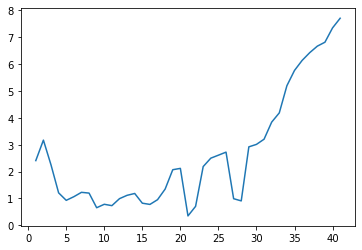

In [49]:
plt.plot(reachability)
reachability

In [27]:
### Labels OPTICS
pd.Series(labels_optics).value_counts()

-1    22
 1     4
 4     4
 5     3
 6     3
 0     2
 2     2
 3     2
dtype: int64

### Making series

In [36]:
### Setting the labels -> DBASCAN / OPTICS
if CLUSTERING_MODEL == 'DBSCAN':
    labels = labels_dbscan
else:
    labels = labels_optics

In [37]:
label_series_all = pd.Series(index = returns.columns,
                         data = labels.flatten())
label_series = label_series_all[label_series_all != -1]

counts = label_series.value_counts()
counts_above_1 = counts[counts>1]

print(f"Clusters formed: {len(counts): >5}")
print(f"Pairs to evaluate: {(counts_above_1 * (counts_above_1) - 1).sum(): >3}")

Clusters formed:     7
Pairs to evaluate:  55


In [38]:
counts[counts>1];

### Plotting, T-SNE

In [39]:
label_series

AKER                               0
AKRBP                              0
EQNR                               1
FRO                                1
GJF                                1
GOGL                               1
NEL                                2
NOD                                2
NHY                                3
ORK                                3
SCHA                               4
STB                                4
SUBC                               4
TEL                                4
ATLAS COPCO A                      5
ERICSSON B                         5
VOLVO B                            5
SANDVIK                            6
ASSA ABLOY B                       6
SKANDINAVISKA ENSKILDA BANKEN A    6
dtype: int32

#### matplotlib

In [40]:
### Transforming data

tsne = TSNE(learning_rate=10, perplexity=25, random_state=123)
X_tsne = tsne.fit_transform(X)
tsne.get_params()
tsne.embedding_
X_tsne.shape

(42, 2)

Text(0.5, 1.0, 'Rechability plot')

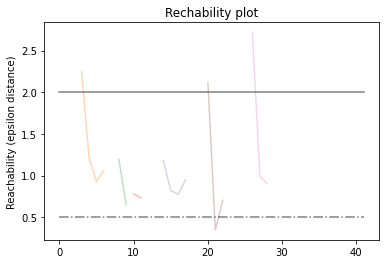

In [58]:
fig, ax1 = plt.subplots()

space = np.arange(len(X))

# looping through all the clusters
for klass in range(len(counts)):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, alpha=0.3)
    
# ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3) # labels = -1 --> not beeing a part of any cluster
ax1.plot(space, np.full_like(space, 2.0, dtype=float), 'k-', alpha=0.5)    #hline1
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)   #hline2
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Rechability plot')

In [85]:
import plotly.express as px

fig = go.Figure()

# looping through all the clusters
for klass in range(len(counts)):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    
    fig.add_trace(
        go.Scatter(
        x = Xk,
        y = Rk,
        mode = 'markers',
        name= klass
    ))
    
fig.add_hline(y=0.5,
              line_width = 1,
              line_dash = 'dashdot',
              line_color = 'black')
fig.add_hline(y=2.0,
              line_width = 1,
              line_dash = 'dash',
              line_color = 'black')
    
fig.update_layout(title = f'Reachability plot {CLUSTERING_MODEL}',

              width=1000,
              height=400,

              yaxis_zeroline=False,
              yaxis=dict(showgrid=False,
                         title='Reachability (epsilon distance)'),
#                   yaxis_showticklabels = False,

              xaxis_zeroline=False,
              xaxis=dict(showgrid=False),
                  xaxis_showticklabels = False,

              legend_title_text = ' Possible clusters:',
             )

fig.show()
 

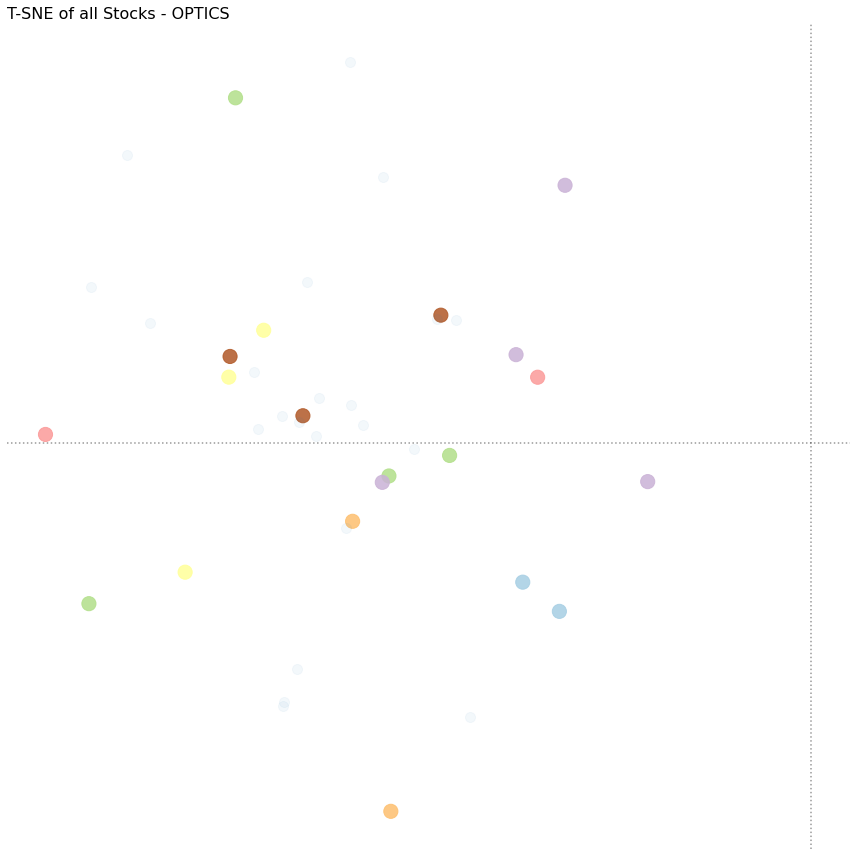

In [41]:
### Plotting data

plt.figure(figsize=(12,12))
plt.clf()
plt.axis('off')
plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=200,
    alpha=0.85,
    marker='o',
    label = label_series[(label_series == clust)].index,
    c=labels[labels!=-1],
    cmap=cm.Paired
)
plt.scatter(
    X_tsne[(label_series_all==-1).values, 0],
    X_tsne[(label_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)
plt.axhline(y=0, c='k', ls=':', alpha=0.4)
plt.axvline(x=0, c='k', ls=':', alpha=0.4)
plt.title(f'T-SNE of all Stocks - {CLUSTERING_MODEL}', loc='left', fontsize=16);
plt.tight_layout()
plt.show()

#### plotly

In [42]:
fig = go.Figure()

clusters = {}

for clust in set(labels[labels!=-1]):
    

    fig.add_trace(go.Scatter(
                        x = X_tsne[(labels==clust), 0],
                        y = X_tsne[(labels==clust), 1],
                        mode = 'markers+text',
                        text = label_series[(label_series == clust)].index,
                        marker = dict(color=clust,
                                      size=10),
                        name = f'C{clust} -> {len(X_tsne[(labels==clust)])} points',
                        opacity = 1
    ))
    
    ### Fasilitating adding of shapes later on
    
    x = X_tsne[(labels==clust), 0]
    y = X_tsne[(labels==clust), 1]
    
    margin = 0.3
    clusters[f'Cluster{clust}'] = [dict(type='circle',
                                   xref='x', yref='y',
                                   x0=min(x) - margin, y0=min(y) - margin,
                                   x1=max(x) + margin, y1=max(y) + margin,
                                   line=dict(color=clust))]

### Noise points

# fig.add_trace(go.Scatter(
#                     x = X_tsne[(label_series_all ==-1), 0],
#                     y = X_tsne[(label_series_all ==-1), 1],
#                     mode = 'markers',
#                     marker = dict(color='blue'),
#                     name = 'non-cluster',
#                     opacity = 0.1
# ))

### Making buttons

buttons = {}
for c, v in clusters.items():
    buttons[c] = dict(label  = c,
                      method = 'relayout',
                      args   = ['shapes', v])
    
    
    
    



fig.update_layout(title = f'Automatic Clustering {CLUSTERING_MODEL}',
                  
                  width=1000,
                  height=800,
                  
                  yaxis_zeroline=False,
                  yaxis=dict(showgrid=False),
#                   yaxis_showticklabels = False,
                  
                  xaxis_zeroline=False,
                  xaxis=dict(showgrid=False),
#                   xaxis_showticklabels = False,
                  
                  legend_title_text = 'Clusters:',
                  
#                       updatemenus = [
        
#                         dict(buttons=list(buttons.values()))
#                       ]
                 )



In [113]:
from plotly.subplots import make_subplots

colors = ['red', 'blue', 'green', 'pink', 'purple', 'grey']

fig = make_subplots(rows=2,
                    cols=1,
                    row_heights=[0.8,0.2],
                    vertical_spacing=0.1,
                    row_titles=['', 'Reachability']
                   )

clusters = {}
for clust, c in zip(set(labels[labels!=-1]), colors):
    fig.add_trace(go.Scatter(
                        x = X_tsne[(labels==clust), 0],
                        y = X_tsne[(labels==clust), 1],
                        mode = 'markers+text',
                        text = label_series[(label_series == clust)].index,
                        marker = dict(color=c,
                                      size=10),
#                         name = f'C{clust} -> {len(X_tsne[(labels==clust)])} points',
                        opacity = 1
    ), row=1,col=1)
    
for klass, c in zip(range(len(counts)), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    
    fig.add_trace(
        go.Scatter(
        x = Xk,
        y = Rk,
        mode = 'markers',
        name= klass,
        marker = dict(color=c,size=8),
    ), row=2, col=1)
    
fig.add_hline(y=0.5,
              line_width = 1,
              line_dash = 'dashdot',
              line_color = 'black', row=2,col=1)
fig.add_hline(y=2.0,
              line_width = 1,
              line_dash = 'dash',
              line_color = 'black', row=2,col=1)


fig.update_layout(title = f'Automatic Clustering {CLUSTERING_MODEL}',
                  
                  width=1000,
                  height=800,
                  
                  yaxis_zeroline=False,
                  yaxis=dict(showgrid=False),
#                   yaxis_showticklabels = False,
                  
                  xaxis_zeroline=False,
                  xaxis=dict(showgrid=False),
#                   xaxis_showticklabels = False,
                  
                  legend_title_text = 'Clusters:',
#                   showlegend=False
                  
#                       updatemenus = [
        
#                         dict(buttons=list(buttons.values()))
#                       ]
                 )

fig.update_yaxes(title_text='hell', row=1, col=2)




### Get pairs

In [184]:
label_series

BAKKA                              0
GJF                                1
MOWI                               0
ORK                                1
SALM                               0
TEL                                1
ATLAS COPCO A                      2
VOLVO B                            2
HEXAGON B                          2
INVESTOR B                         2
SANDVIK                            2
ASSA ABLOY B                       2
SKANDINAVISKA ENSKILDA BANKEN A    3
SVENSKA HANDELSBANKEN A            3
SWEDBANK A                         3
ALFA LAVAL                         2
TELIA COMPANY                      2
LATOUR INVESTMENT B                2
NIBE INDUSTRIER                    2
dtype: int64

In [166]:
cluster_list = list(counts_above_1.index)

all_clusters = []

for clust in cluster_list:
    all_clusters.append(list(label_series[label_series==clust].index))

all_clusters

[['ATLAS COPCO A',
  'VOLVO B',
  'HEXAGON B',
  'INVESTOR B',
  'SANDVIK',
  'ASSA ABLOY B',
  'ALFA LAVAL',
  'TELIA COMPANY',
  'LATOUR INVESTMENT B',
  'NIBE INDUSTRIER'],
 ['BAKKA', 'MOWI', 'SALM'],
 ['GJF', 'ORK', 'TEL'],
 ['SKANDINAVISKA ENSKILDA BANKEN A', 'SVENSKA HANDELSBANKEN A', 'SWEDBANK A']]

### Cointegration test

In [338]:


def find_cointegrated_pairs(data: pd.DataFrame,
                            significance: float = 0.05) -> tuple:
    """Function calculating cointegration measures for the given data"""
    
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    
    for i in range(n):
        
        for j in range(i+1, n):
            
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
                
    return score_matrix, pvalue_matrix, pairs


In [339]:
cluster_dict = {}
data = returns

for i, which_clust in enumerate(counts_above_1.index):
    tickers = label_series[label_series == which_clust].index
    
    ### Calling function
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        data[tickers]
    )
    
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs
    
pairs = []

for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])
    

In [340]:
### Example of pairs being added to the "pairs" list

cluster_dict[2]['pairs']

[('LVMH', 'CHRISTIAN DIOR'), ('LVMH', 'KERING'), ('CHRISTIAN DIOR', 'KERING')]

In [341]:
len(pairs)

89

In [342]:
pairs
# pairs[2]

[("L'OREAL", 'SANOFI'),
 ("L'OREAL", 'SCHNEIDER ELECTRIC'),
 ("L'OREAL", 'ESSILORLUXOTTICA'),
 ("L'OREAL", 'L AIR LQE.SC.ANYME. POUR L ETUDE ET L EPXTN.'),
 ("L'OREAL", 'AXA'),
 ("L'OREAL", 'PERNOD-RICARD'),
 ("L'OREAL", 'DANONE'),
 ("L'OREAL", 'ORANGE'),
 ("L'OREAL", 'SAINT GOBAIN'),
 ("L'OREAL", 'CARREFOUR'),
 ("L'OREAL", 'CMPG.DES ETS.MICH.'),
 ("L'OREAL", 'LEGRAND'),
 ('SANOFI', 'SCHNEIDER ELECTRIC'),
 ('SANOFI', 'ESSILORLUXOTTICA'),
 ('SANOFI', 'L AIR LQE.SC.ANYME. POUR L ETUDE ET L EPXTN.'),
 ('SANOFI', 'AXA'),
 ('SANOFI', 'PERNOD-RICARD'),
 ('SANOFI', 'DANONE'),
 ('SANOFI', 'ORANGE'),
 ('SANOFI', 'SAINT GOBAIN'),
 ('SANOFI', 'CARREFOUR'),
 ('SANOFI', 'CMPG.DES ETS.MICH.'),
 ('SANOFI', 'LEGRAND'),
 ('SCHNEIDER ELECTRIC', 'ESSILORLUXOTTICA'),
 ('SCHNEIDER ELECTRIC', 'L AIR LQE.SC.ANYME. POUR L ETUDE ET L EPXTN.'),
 ('SCHNEIDER ELECTRIC', 'AXA'),
 ('SCHNEIDER ELECTRIC', 'PERNOD-RICARD'),
 ('SCHNEIDER ELECTRIC', 'DANONE'),
 ('SCHNEIDER ELECTRIC', 'ORANGE'),
 ('SCHNEIDER ELECTRIC', '